In [2]:
from scipy.stats import kurtosis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
my_random_state = 318
import time
import random

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, normalize
from sklearn.metrics import accuracy_score,plot_confusion_matrix, confusion_matrix


from sklearn.neural_network import MLPClassifier

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA, FastICA, NMF
from sklearn.random_projection import GaussianRandomProjection as RP

clusterings = ['KMeans','EM']
dimReductions = ['PCA','ICA', 'RP', 'IG']

In [3]:
###### E-coli 
### http://archive.ics.uci.edu/ml/datasets/Ecoli
# data = pd.read_csv('datafiles/ecoli.csv')))  # very unbalanced
# class_names = np.array(['cp', 'im', 'imL', 'imS', 'imU','om','omL','pp'])
data = pd.read_csv('datafiles/ecoli-balance.csv') # balanced: merged sub-species of E-coli
class_names = np.array(['cp', 'im', 'om','pp'])
y_data = data.Y
x_data = data.loc[:,'X1':'X7']


one_hot = OneHotEncoder()
y_data_hot = one_hot.fit_transform(y_data.values.reshape(-1, 1)).todense()
# y_test_hot = le.transform(y_test.reshape(-1, 1)).todense()
y_data_hot.shape


le = LabelEncoder()
le.fit(y_data.values.tolist())
y_data_le = le.transform(y_data)
y_data_le.shape

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data_le, train_size=0.7, random_state=my_random_state, shuffle=True)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(235, 7) (101, 7) (235,) (101,)


In [10]:
thisDR = 'noDR'
x_train_transform = x_train
x_test_transform = x_test

# PCA

In [12]:
# 4 component is best (beyond elbow & cum var > 0.9)
thisDR = 'PCA'
best_n_components = 4
bestDR = PCA(n_components=best_n_components)
x_train_transform = bestDR.fit_transform(x_train)
x_test_transform = bestDR.fit_transform(x_test)
x_train_inverse = bestDR.inverse_transform(x_train_transform)

# Reconstruction Error
mse = np.sum(np.square(x_train.values - x_train_inverse))/x_train_inverse.size
print('MSE: ', mse)
#  MSE:  0.002285813672259965 for n=4

MSE:  0.008370548519702078


# ICA

In [19]:
thisDR = 'ICA'
# 6 component is best (max kurtosis)
best_n_components = 6
bestDR = FastICA(n_components=best_n_components, random_state = my_random_state)
x_train_transform = bestDR.fit_transform(x_train)
x_test_transform = bestDR.fit_transform(x_test)
x_train_inverse = bestDR.inverse_transform(x_train_transform)


# Reconstruction Error
mse = np.sum(np.square(x_train.values - x_train_inverse))/x_train_inverse.size
print('MSE: ', mse)
#  MSE:  0.02573452901766932 for n=6

MSE:  0.02573452901766932


# RP

In [23]:
thisDR = 'RP'
# 5 component is best (relatively min MSE)
best_n_components = 5
bestDR = RP(n_components=best_n_components, random_state = my_random_state)
x_train_transform = bestDR.fit_transform(x_train)
x_test_transform = bestDR.fit_transform(x_test)

x_train_inverse = np.linalg.pinv(bestDR.components_.T)
x_train_reconstruct = x_train_transform.dot(x_train_inverse)
# Reconstruction Error
mse = np.sum(np.square(x_train.values - x_train_reconstruct))/x_train_reconstruct.size
print('MSE: ', mse)
#  MSE:  0.04266261920459053 for n=5

MSE:  0.04266261920459053


# NMF

In [16]:
thisDR = 'NMF'
best_n_components = 7
bestDR = NMF(n_components=best_n_components, random_state = my_random_state)
x_train_transform = bestDR.fit_transform(x_train)
x_test_transform = bestDR.fit_transform(x_test)
x_train_inverse = bestDR.inverse_transform(x_train_transform)

# Reconstruction Error
mse = np.sum(np.square(x_train.values - x_train_inverse))/x_train_inverse.size
print('MSE: ', mse)


# run NN

In [24]:
############## using GridSearch
nn3layer = MLPClassifier(random_state=my_random_state, hidden_layer_sizes = (20,20,20))
alpha_range = np.logspace(-4, 3, 8)
learningrate_range = np.logspace(-4, 1, 6)
parameters = {'alpha':alpha_range, 'learning_rate_init': learningrate_range}
grid_nn = GridSearchCV(nn3layer, parameters)

tic = time.perf_counter() 
grid_nn.fit(x_train_transform, y_train)
toc = time.perf_counter() 
print(f"training time for {thisDR} is {toc - tic} seconds")
print()

print(f"{thisDR}: best parameters & score from GridSearchCV: ")
print(grid_nn.best_params_)
print(grid_nn.best_score_)
print()

C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

training time for RP is 27.49792350000007 seconds

RP: best parameters & score from GridSearchCV: 
{'alpha': 0.1, 'learning_rate_init': 0.01}
0.9276595744680851



RP: Prediction accuracy on train set: 
0.9531914893617022

testing time for RP is 0.0006620999999995547 seconds
RP: Prediction accuracy on test set: 
0.9504950495049505


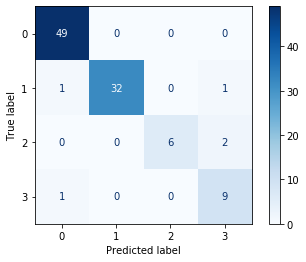

In [25]:

y_train_nn = grid_nn.predict(x_train_transform)
print(f"{thisDR}: Prediction accuracy on train set: ")
print(accuracy_score(y_train,y_train_nn))
print()

tic = time.perf_counter() 
y_test_nn = grid_nn.predict(x_test_transform)
toc = time.perf_counter() 
print(f"testing time for {thisDR} is {toc - tic} seconds")
print(f"{thisDR}: Prediction accuracy on test set: ")
print(accuracy_score(y_test,y_test_nn))



# plot_confusion_matrix(grid_nn, x_test, y_test,normalize='true',cmap=plt.cm.Blues)
# plt.savefig(f'NN/nn_{thisDR}_confusion_matrix_normalized.png') 
# plt.show()

plot_confusion_matrix(grid_nn, x_test_transform, y_test,cmap=plt.cm.Blues)
plt.savefig(f'NN/nn_{thisDR}_confusion.png') 
plt.show()